In [87]:
%run mpl_config.py

In [88]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from eda_helper import get_custom_palette, get_custom_heatmap, get_custom_colormap

custom_palette = get_custom_palette()
custom_heatmap = get_custom_heatmap()
custom_colormap = get_custom_colormap()

print(os.getcwd())

c:\#code\#python\#current\mres-project\analysis_files


In [5]:
from tabulate import tabulate

# Create the data
data = {
    "1s": f"{round(100-68.27, 2)}%",
    "2s": f"{round(100-95.45, 2)}%",
    "3s": f"{round(100-99.73, 2)}%",
    "4s": f"{round(100-99.99, 2)}%",
}

# Convert dictionary to list of lists for tabulation
table_data = [[key, value] for key, value in data.items()]

# Generate the table
table = tabulate(
    table_data, headers=["Standard Deviation", "Percentage"], tablefmt="grid"
)

print(table)

+----------------------+--------------+
| Standard Deviation   | Percentage   |
+======================+==============+
| 1s                   | 31.73%       |
+----------------------+--------------+
| 2s                   | 4.55%        |
+----------------------+--------------+
| 3s                   | 0.27%        |
+----------------------+--------------+
| 4s                   | 0.01%        |
+----------------------+--------------+


In [89]:
cwd = os.getcwd()
column_names = [
    "MAE",
    "MSE",
    "RMSE",
    "R^2",
    "Model",
    "Training Time (s)",
    "Test Number",
    "Completeness",
    "Sequence Length",
    "WindowSize",
    "Horizon",
]
performance = pd.read_csv(
    cwd + "\\performance_metrics_mm.csv", header=None, names=column_names
)
runtime = pd.read_csv(cwd + "\\runtime_metrics_mm.csv")
weights = pd.read_csv(cwd + "\\weights_mm.csv")

In [90]:
selected_columns = [
    "MAE",
    "MSE",
    "RMSE",
    "R^2",
    "Training Time (s)",
    "Test Number",
    "Completeness",
    "Sequence Length",
    "WindowSize",
    "Horizon",
]

performance_lstm = performance[performance["Model"] == "LSTM"][selected_columns]
performance_linear = performance[performance["Model"] == "Linear"][selected_columns]


def process_data(dataframe):
    """
    Process the given dataframe based on the provided steps.
    Args:
    - dataframe (pd.DataFrame): The dataframe to process.
    Returns:
    - pd.DataFrame: The processed dataframe.
    """
    dataframe = dataframe.sort_values(by="R^2").reset_index(drop=True)
    grouped_dataframe = dataframe.groupby(
        ["Completeness", "Horizon", "WindowSize"]
    ).mean()
    grouped_dataframe.reset_index(inplace=True)
    sorted_dataframe = grouped_dataframe.sort_values(
        by="Training Time (s)"
    ).reset_index(drop=True)

    return sorted_dataframe


# Process the dataframes
sorted_lstm_performance = process_data(performance_lstm)
sorted_linear_performance = process_data(performance_linear)

# Multiplying index value by length of window_sizes to get the correct index for viewing
sorted_linear_performance.index = sorted_lstm_performance.iloc[::6].index

window_values = np.sort(sorted_lstm_performance["WindowSize"].unique())
horizon_values = np.sort(sorted_lstm_performance["Horizon"].unique())
completeness_values = np.sort(sorted_lstm_performance["Completeness"].unique())

# Additional operations for linear_data
sorted_linear_performance = sorted_linear_performance.sort_values(
    ["Completeness", "Horizon"], ascending=[False, True]
).reset_index(drop=True)

In [91]:
print(
    "Unique Values in Performance Dataframe:",
    "\n",
    "Sequence Length",
    len(performance["Sequence Length"].unique()),
    "\n",
    "Completeness",
    len(performance["Completeness"].unique()),
    "\n",
    "Horizon",
    len(performance["Horizon"].unique()),
    "\n",
    "Window Size",
    len(performance["WindowSize"].unique()),
    "\n",
    "Test Number",
    len(performance["Test Number"].unique()),
    "\n",
)

Unique Values in Performance Dataframe: 
 Sequence Length 15 
 Completeness 4 
 Horizon 4 
 Window Size 7 
 Test Number 405 



In [92]:
print(
    f"Performance value counts \n {performance['Model'].value_counts()} \n {performance['Completeness'].value_counts()} \n {performance['WindowSize'].value_counts()} \n {performance['Horizon'].value_counts()}"
)

Performance value counts 
 Model
LSTM      347
Linear     58
Name: count, dtype: int64 
 Completeness
0.98    140
0.96    140
1.00    112
0.94     13
Name: count, dtype: int64 
 WindowSize
1     58
3     58
6     58
12    58
24    58
48    58
96    57
Name: count, dtype: int64 
 Horizon
3     105
6     104
12     98
24     98
Name: count, dtype: int64


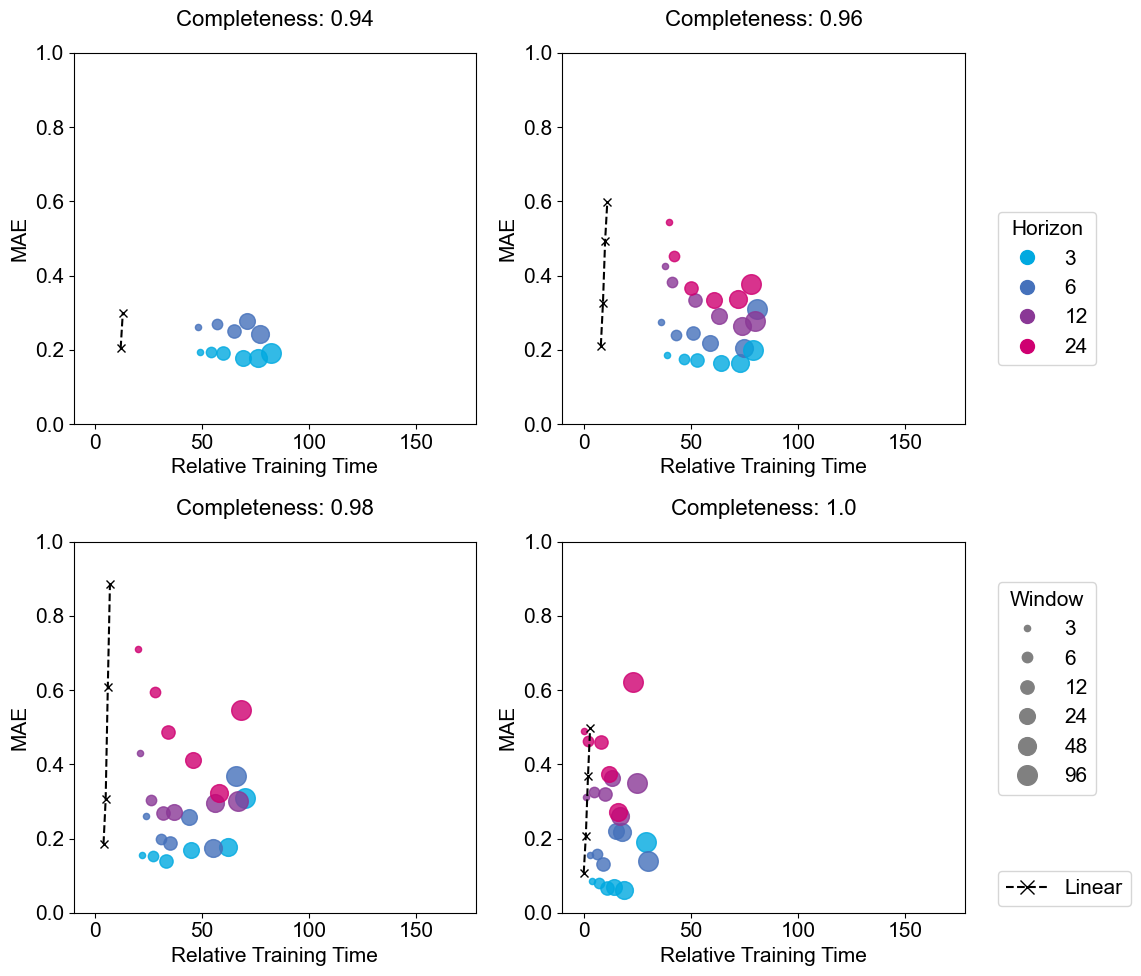

In [93]:
window_values = np.sort(sorted_lstm_performance["WindowSize"].unique())
horizon_values = np.sort(sorted_lstm_performance["Horizon"].unique())
completeness_values = np.sort(sorted_lstm_performance["Completeness"].unique())

# Swap colors for horizon and sizes for window values
colors = custom_heatmap(np.linspace(0, 1, len(horizon_values)))
size_values = np.linspace(20, 200, len(window_values))

color_legend_elements = []  # For color legend (horizons)
size_legend_elements = []  # For size legend (window sizes)
# Legend element for linear performance
linear_legend_element = plt.Line2D(
    [0], [0], color="black", marker="x", linestyle="--", markersize=10, label="Linear"
)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # Flatten the array of axes to loop through

for k, completeness in enumerate(completeness_values):
    ax = axs[k]
    linear_data = sorted_linear_performance[
        sorted_linear_performance["Completeness"] == completeness
    ]["MAE"]
    ax.plot(
        linear_data.index,
        linear_data,
        linestyle="--",
        color="black",
        marker="x",
        label="Linear",
    )
    for i, window_size in enumerate(window_values):
        for j, horizon in enumerate(horizon_values):
            data = sorted_lstm_performance[
                (sorted_lstm_performance["WindowSize"] == window_size)
                & (sorted_lstm_performance["Horizon"] == horizon)
                & (sorted_lstm_performance["Completeness"] == completeness)
            ]["MAE"]

            ax.scatter(
                data.index,
                data,
                s=size_values[i],
                color=colors[j],
                marker="o",
                alpha=0.8,
            )

            # Populating the legend elements
            if k == 0:  # Only do this once
                if i == 0:
                    color_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color=colors[j],
                            marker="o",
                            linestyle="",
                            markersize=10,
                            label=horizon,
                        )
                    )
                if j == 0:
                    size_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color="grey",
                            marker="o",
                            linestyle="",
                            markersize=size_values[i] ** 0.5,
                            label=window_size,
                        )
                    )

    # Set titles, labels for each subplot
    ax.set_title(f"Completeness: {completeness}", y=1.05)
    ax.set_xlabel("Relative Training Time")
    ax.set_ylabel("MAE")
    ax.set_ylim(0, 1)
    ax.set_xlim(-10, 168 + 10)

# Adding a shared legend outside of the whole figure
fig.legend(
    handles=color_legend_elements,
    title="Horizon",
    loc="center left",
    bbox_to_anchor=(1, 0.7),
)
fig.legend(
    handles=size_legend_elements,
    title="Window",
    loc="center left",
    bbox_to_anchor=(1, 0.3),
)
fig.legend(
    handles=[linear_legend_element],
    loc="center left",
    bbox_to_anchor=(1, 0.1),
)

plt.tight_layout()
plt.show()

In [94]:
data

23    0.620684
Name: MAE, dtype: float64

Window values: [ 3  6 12 24 48 96]
Horizon values: [ 3  6 12 24]
Completeness values: [0.94 0.96 0.98 1.  ]


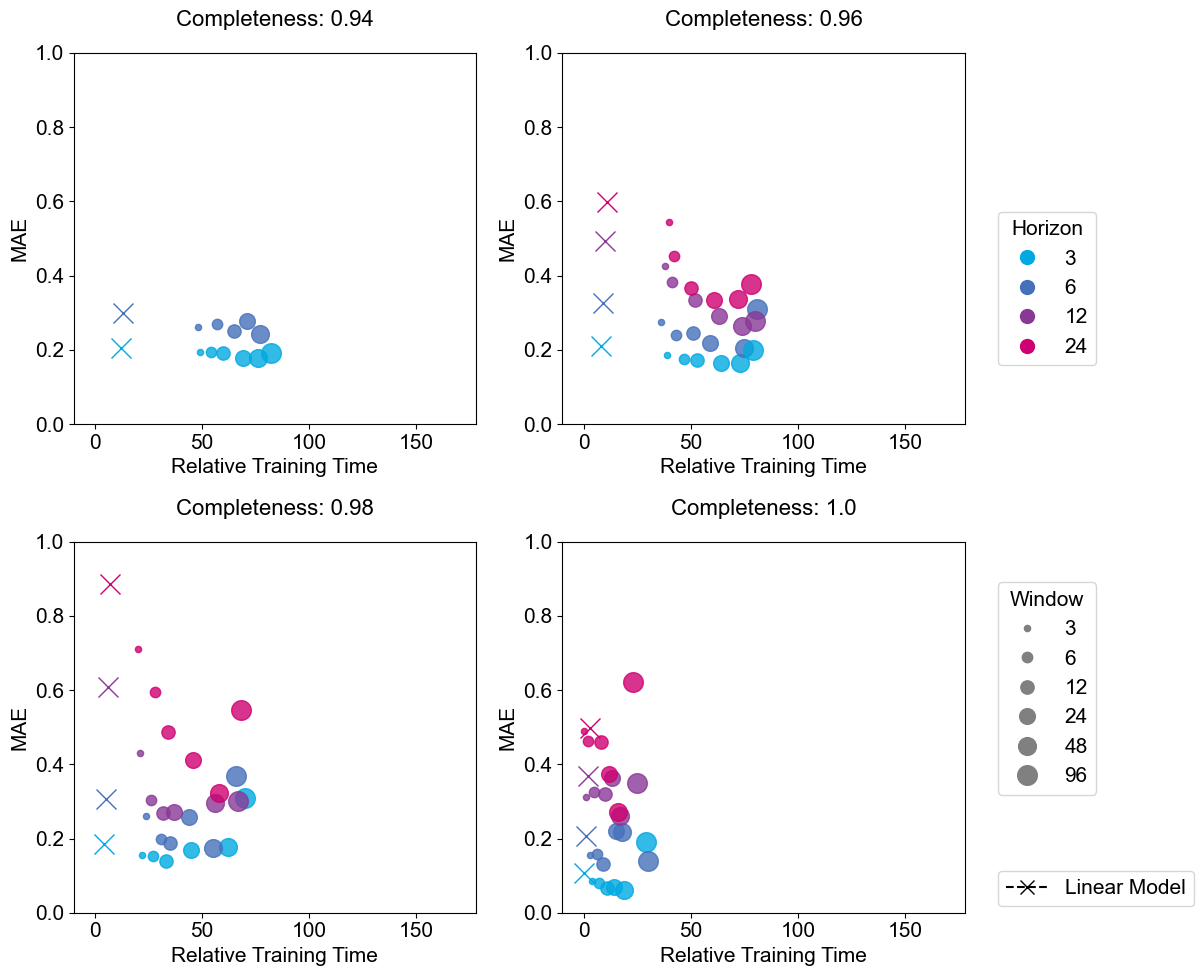

In [95]:
print("Window values:", window_values)
print("Horizon values:", horizon_values)
print("Completeness values:", completeness_values)

# Swap colors for horizon and sizes for window values
colors = custom_heatmap(np.linspace(0, 1, len(horizon_values)))
size_values = np.linspace(20, 200, len(window_values))

color_legend_elements = []  # For color legend (horizons)
size_legend_elements = []  # For size legend (window sizes)
# Legend element for linear performance
linear_legend_element = plt.Line2D(
    [0],
    [0],
    color="black",
    marker="x",
    linestyle="--",
    markersize=10,
    label="Linear Model",
)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # Flatten the array of axes to loop through

for k, completeness in enumerate(completeness_values):
    ax = axs[k]

    # Plotting the sorted_linear_performance on the same axes
    for j, horizon in enumerate(horizon_values):
        linear_data = sorted_linear_performance[
            (sorted_linear_performance["Horizon"] == horizon)
            & (sorted_linear_performance["Completeness"] == completeness)
        ]["MAE"]

        if (
            not linear_data.empty
        ):  # Check if there's data for the given horizon and completeness
            ax.plot(
                linear_data.index,
                linear_data,
                linestyle="--",
                color=colors[j],
                marker="x",
                label=f"Linear {horizon}",
                markersize=15,
            )

    for i, window_size in enumerate(window_values):
        for j, horizon in enumerate(horizon_values):
            data = sorted_lstm_performance[
                (sorted_lstm_performance["WindowSize"] == window_size)
                & (sorted_lstm_performance["Horizon"] == horizon)
                & (sorted_lstm_performance["Completeness"] == completeness)
            ]["MAE"]

            ax.scatter(
                data.index,
                data,
                s=size_values[i],
                color=colors[j],
                marker="o",
                alpha=0.8,
            )

            # Populating the legend elements
            if k == 0:  # Only do this once
                if i == 0:
                    color_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color=colors[j],
                            marker="o",
                            linestyle="",
                            markersize=10,
                            label=horizon,
                        )
                    )
                if j == 0:
                    size_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color="grey",
                            marker="o",
                            linestyle="",
                            markersize=size_values[i] ** 0.5,
                            label=window_size,
                        )
                    )

    # Set titles, labels for each subplot
    ax.set_title(f"Completeness: {completeness}", y=1.05)
    ax.set_xlabel("Relative Training Time")
    ax.set_ylabel("MAE")
    ax.set_ylim(0, 1)
    ax.set_xlim(-10, 168 + 10)

# Adding a shared legend outside of the whole figure
fig.legend(
    handles=color_legend_elements,
    title="Horizon",
    loc="center left",
    bbox_to_anchor=(1, 0.7),
)
fig.legend(
    handles=size_legend_elements,
    title="Window",
    loc="center left",
    bbox_to_anchor=(1, 0.3),
)
# Add the linear legend element
fig.legend(
    handles=[linear_legend_element],
    loc="center left",
    bbox_to_anchor=(1, 0.1),
)

plt.tight_layout()
plt.show()

In [96]:
data = performance_lstm.sort_values(by="R^2").reset_index(drop=True)

In [97]:
len(performance_lstm[["WindowSize", "Horizon", "Completeness"]].drop_duplicates())

83

In [98]:
sorted_linear_performance

,Completeness,Horizon,WindowSize,MAE,MSE,RMSE,R^2,Training Time (s),Test Number,Sequence Length
0,1.00,3,1,0.106313,0.016079,0.326057,-2.292741,5.200027,43.0,540.0
1,1.00,6,1,0.207583,0.050419,0.455612,-15.835554,5.154387,50.0,540.0
2,1.00,12,1,0.367444,0.144518,0.606171,-54.339219,5.068438,57.0,540.0
3,1.00,24,1,0.498658,0.251231,0.706157,-93.986934,4.724733,64.0,540.0
4,0.98,3,1,0.185316,0.073560,0.430483,0.901574,18.306656,169.0,2082.0
5,0.98,6,1,0.305648,0.165509,0.552854,0.779953,16.833625,176.0,2082.0
6,0.98,12,1,0.607520,0.474800,0.779436,0.371956,17.183776,183.0,2082.0
7,0.98,24,1,0.885997,0.909486,0.941274,-0.183291,17.260773,190.0,2082.0
8,0.96,3,1,0.210710,0.097874,0.459031,0.804495,33.629649,309.0,3864.0
9,0.96,6,1,0.327221,0.191901,0.572032,0.616676,34.617527,316.0,3864.0


          MAE       MSE      RMSE       R^2  Training Time (s)  Test Number  \
1    0.083412  0.013734  0.288811 -1.812594           2.439272            2   
2    0.078647  0.011950  0.280440 -2.990334           2.846594            3   
3    0.080457  0.009422  0.283649 -2.607946           3.496846            4   
4    0.076666  0.007142  0.276887 -1.641749           4.913144            5   
5    0.059132  0.004404  0.243170 -1.186634           6.246385            6   
..        ...       ...       ...       ...                ...          ...   
400  0.262688  0.136500  0.512531  0.657919          20.577650          401   
401  0.270596  0.147103  0.520189  0.631573          28.081038          402   
402  0.251861  0.148574  0.501858  0.628048          37.754581          403   
403  0.276492  0.177182  0.525825  0.557049          56.414933          404   
404  0.241652  0.176368  0.491581  0.562284          87.551414          405   

     Completeness  Sequence Length  WindowSize  Hor

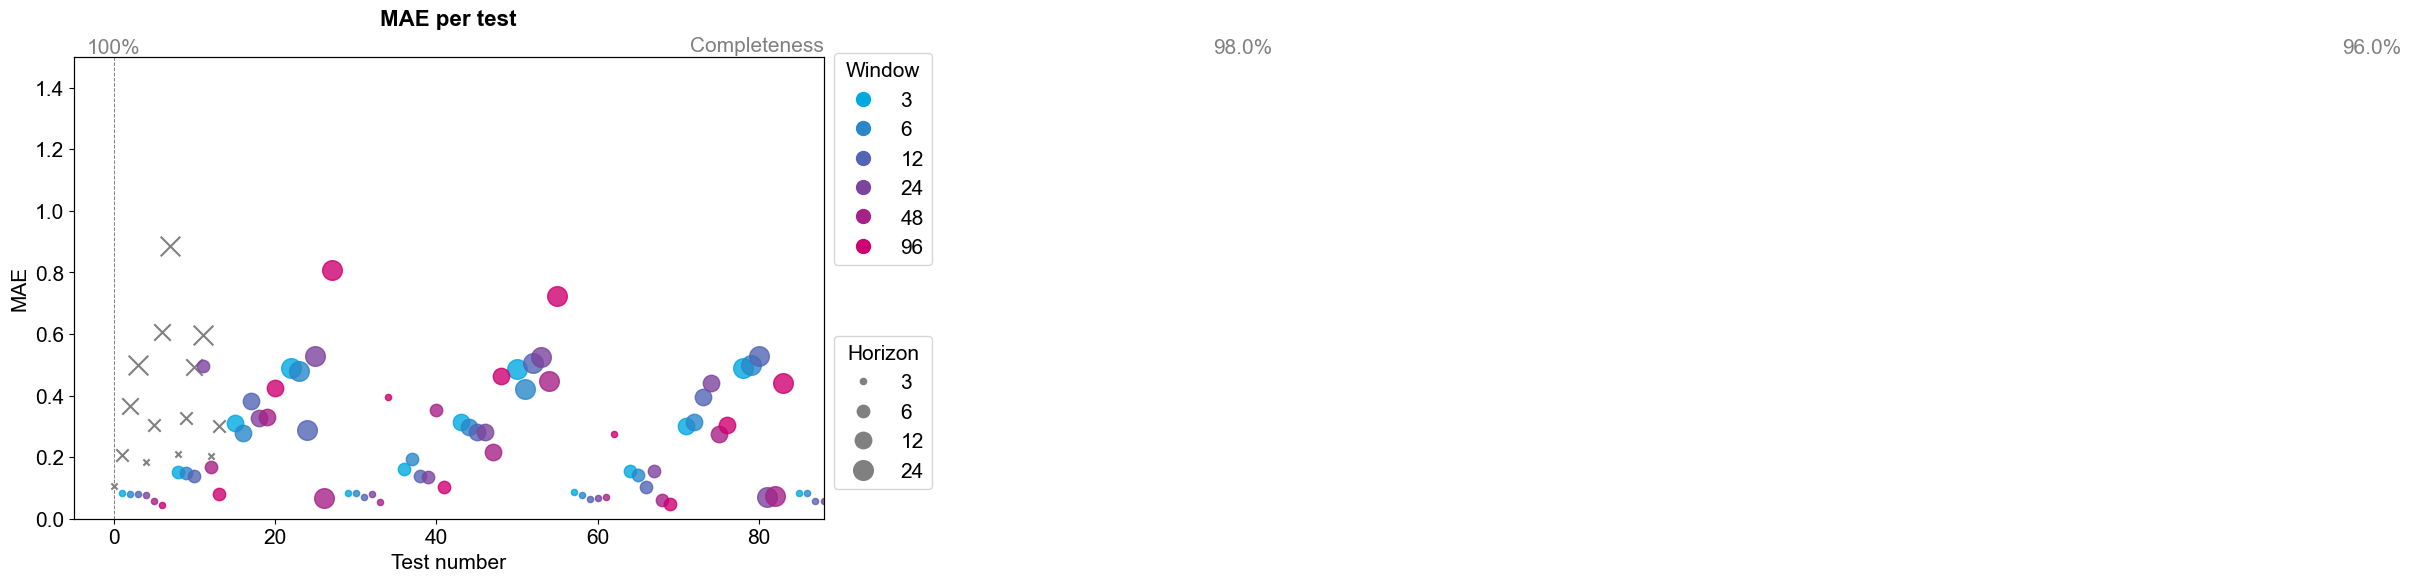

In [99]:
data_input = performance_lstm
# Adjust the figure size to provide space on the right for the legends
fig, ax = plt.subplots(figsize=(12, 6))

# data_input = sorted_performance.iloc[::-1].reset_index(drop=True)
window_values = np.sort(data_input["WindowSize"].unique())  # Sort in ascending order
horizon_values = np.sort(data_input["Horizon"].unique())  # Sort in ascending order

colors = custom_heatmap(np.linspace(0, 1, len(window_values)))
size_values = np.linspace(20, 200, len(horizon_values))

color_legend_elements = []  # For color legend (window sizes)
size_legend_elements = []  # For size legend (horizons)

# Plotting the sorted_linear_performance on the same axes
for i, completeness in enumerate(completeness_values):
    for j, horizon in enumerate(horizon_values):
        linear_data = sorted_linear_performance[
            (sorted_linear_performance["Horizon"] == horizon)
            & (sorted_linear_performance["Completeness"] == completeness)
        ]["MAE"]

        if (
            not linear_data.empty
        ):  # Check if there's data for the given horizon and completeness
            ax.scatter(
                linear_data.index,
                linear_data,
                color="gray",
                marker="x",
                label=f"Linear {horizon}",
                s=size_values[j],
            )

for i, window_size in enumerate(window_values):
    for j, horizon in enumerate(horizon_values):
        data = data_input[
            (data_input["WindowSize"] == window_size)
            & (data_input["Horizon"] == horizon)
        ]["MAE"]

        ax.scatter(
            data.index, data, s=size_values[j], color=colors[i], marker="o", alpha=0.8
        )

        if j == 0:
            color_legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    color=colors[i],
                    marker="o",
                    linestyle="",
                    markersize=10,
                    label=window_size,
                )
            )
        if i == 0:
            size_legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    color="grey",
                    marker="o",
                    linestyle="",
                    markersize=np.sqrt(
                        size_values[j]
                    ),  # Use square root to better represent the sizes visually
                    label=horizon,
                )
            )

# Adjusted the position of legends to the right of the plot
color_legend = ax.legend(
    handles=size_legend_elements,
    title="Horizon",
    loc="center left",
    bbox_to_anchor=(1, 0.23),
)
ax.add_artist(color_legend)
ax.legend(
    handles=color_legend_elements,
    title="Window",
    loc="upper left",
    bbox_to_anchor=(1, 1.03),
)
ax.set_xlabel("Test number")
ax.set_ylabel("MAE")
ax.set_title("MAE per test", y=1.05, fontweight="bold")
ax.set_ylim(0, 1.5)
ax.set_xlim(-5, len(sorted_lstm_performance) + 5)

# Add vertical lines every 84 intervals and label them
max_index = performance_lstm.index.max()

print(performance_lstm)
for x, c in zip(range(0, max_index, 140), [1, 0.98, 0.96, 0.94]):
    ax.axvline(x, color="grey", linestyle="--", linewidth=0.7)
    ax.text(
        x, ax.get_ylim()[1], str(f"{c*100}%"), va="bottom", ha="center", color="grey"
    )

# Add a twin x-axis for the top label
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])  # Hide the ticks
ax2.set_xticklabels([])
ax2.set_xlabel("Completeness", loc="right", color="grey")

plt.subplots_adjust(
    right=0.75
)  # Adjust subplot so there's space for legends on the right
plt.show()

In [100]:
import plotly.express as px

# Sorting data
data_input = sorted_lstm_performance.sort_values(
    by=["Completeness", "Horizon", "WindowSize"], ascending=[False, True, True]
).reset_index(drop=True)

window_values = np.sort(data_input["WindowSize"].unique())
horizon_values = np.sort(data_input["Horizon"].unique())
colors = custom_heatmap(np.linspace(0, 1, len(window_values)))

# We create a new column for colors and sizes for the plot
data_input["color"] = data_input["WindowSize"].apply(
    lambda x: colors[list(window_values).index(x)]
)
data_input["size"] = data_input["Horizon"].apply(
    lambda x: np.linspace(20, 200, len(horizon_values))[list(horizon_values).index(x)]
)

# Interactive scatter plot
fig = px.scatter(
    data_input,
    x=data_input.index,
    y="MAE",
    size="size",
    hover_data=["Horizon", "WindowSize", "RMSE", "R^2", "Training Time (s)"],
    title="MAE per test",
    labels={"MAE": "MAE", "index": "Test number"},
    range_y=[0, 1.5],
)

fig.update_layout(showlegend=True)  # Hide default legend

# Display the plot
fig.show()

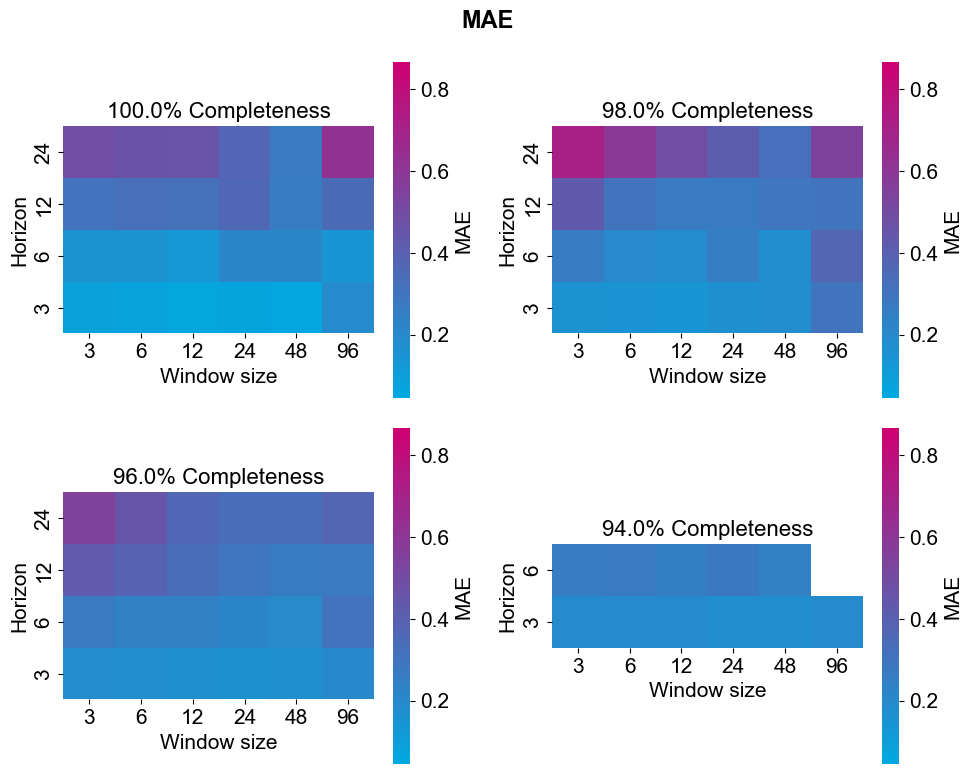

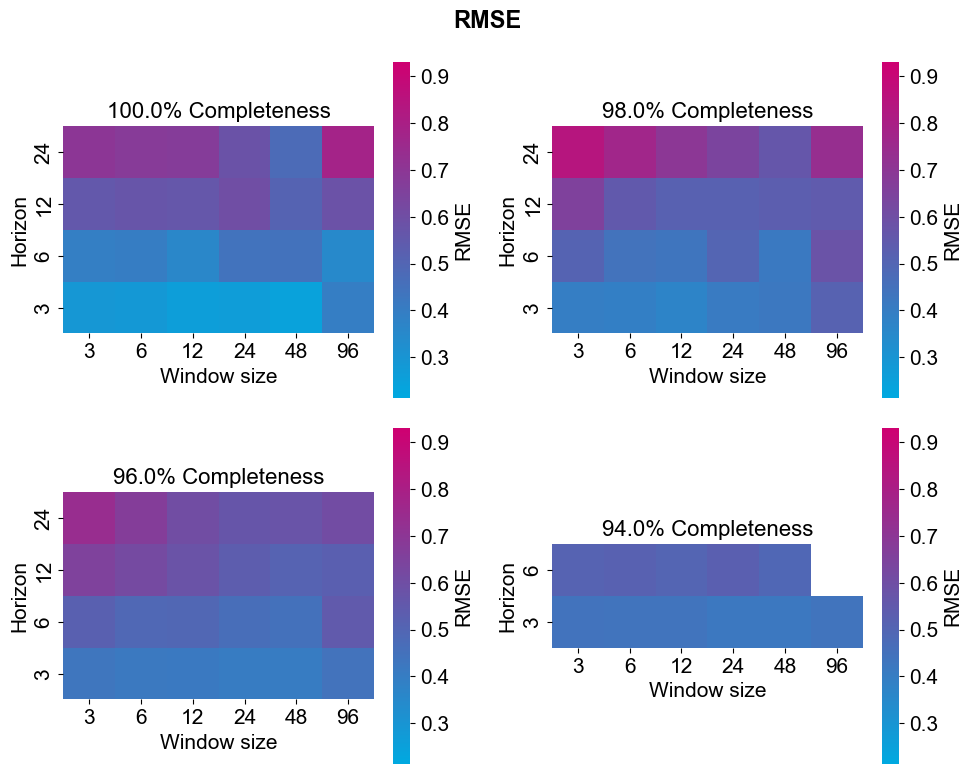

Global vmin for R^2: 0, vmax: 0.9547716621999516


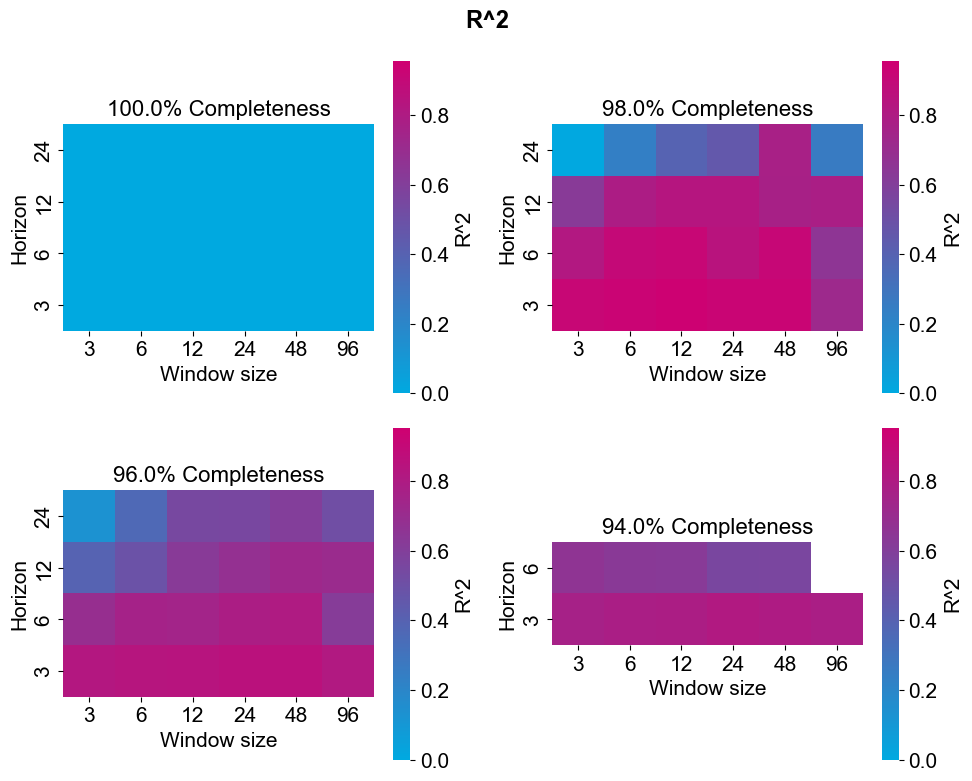

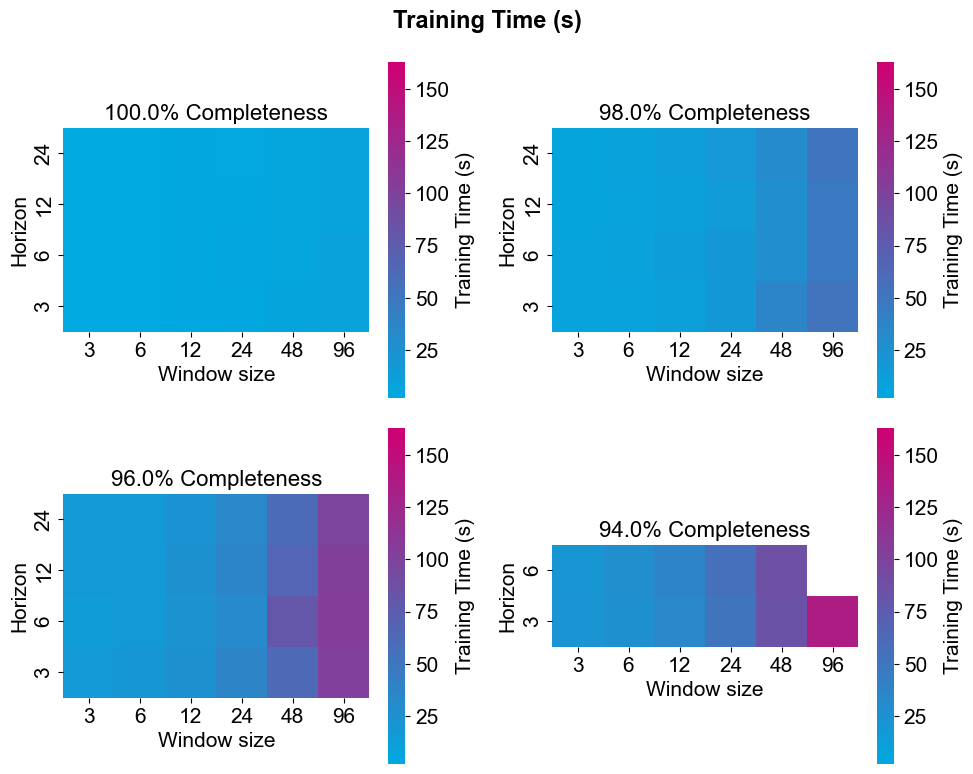

In [101]:
for metric in ["MAE", "RMSE", "R^2", "Training Time (s)"]:
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    # Calculate global vmin and vmax for the metric
    vmin = performance_lstm[metric].min() if performance_lstm[metric].min() >= 0 else 0
    vmax = performance_lstm[metric].max()

    if metric == "R^2":
        print(f"Global vmin for {metric}: {vmin}, vmax: {vmax}")

    # Loop over all completeness values
    for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
        # Subset
        subset = performance_lstm[performance_lstm["Completeness"] == completeness]

        # Pivot table for heatmap
        data_pivot = subset.pivot_table(
            index="Horizon", columns="WindowSize", values=metric, aggfunc="mean"
        )

        # Heatmap (choropleth)
        sns.heatmap(
            data_pivot,
            cmap=custom_heatmap,
            ax=ax[i // 2][i % 2],
            cbar_kws={"label": metric},
            vmin=vmin,
            vmax=vmax,
            square=True,  # This makes each cell square-shaped
        )

        # Add other plot details
        ax[i // 2][i % 2].set_title(f"{completeness*100}% Completeness")
        ax[i // 2][i % 2].set_xlabel("Window size")
        ax[i // 2][i % 2].set_ylabel("Horizon")
        ax[i // 2][i % 2].set_aspect("equal", "box")  # Set the aspect of the axis
        ax[i // 2][i % 2].invert_yaxis()  # Reverse the y-axis

    fig.suptitle(metric)

    plt.tight_layout()
    plt.show()

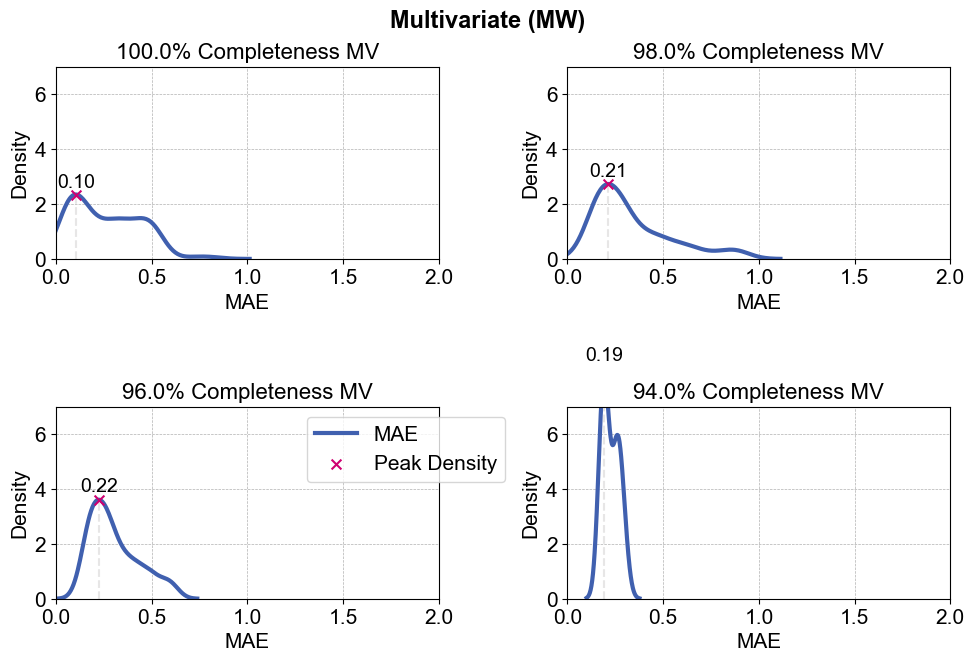

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from eda_helper import get_custom_palette

custom_palette = get_custom_palette()

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i, completeness in enumerate(performance["Completeness"].unique()):
    # Subset
    subset = performance[performance["Completeness"] == completeness]

    # Draw the density plot
    sns.kdeplot(subset["MAE"], linewidth=3, label="MAE", ax=ax[i // 2][i % 2])

    # Compute KDE values
    mae_values = np.linspace(subset["MAE"].min(), subset["MAE"].max(), 1000)
    kde_func = gaussian_kde(subset["MAE"].values)
    kde_values = kde_func(mae_values)

    # Find the MAE value with the maximum KDE
    max_mae_value = mae_values[np.argmax(kde_values)]
    max_kde_value = kde_values[np.argmax(kde_values)]

    # Plot the point at peak density
    ax[i // 2][i % 2].scatter(
        max_mae_value,
        max_kde_value,
        color=custom_palette[7],
        s=50,
        zorder=5,
        label="Peak Density",
        marker="x",
    )

    # Draw a vertical line from the scatter point
    ax[i // 2][i % 2].vlines(
        max_mae_value, 0, max_kde_value, linestyles="dashed", colors=custom_palette[4]
    )

    # Label the point with its x coordinate
    ax[i // 2][i % 2].text(
        max_mae_value,
        max_kde_value * 1.04,
        f"{max_mae_value:.2f}",
        ha="center",
        va="bottom",
        fontsize=14,
    )

    ax[i // 2][i % 2].set_title(f"{completeness*100}% Completeness MV")
    ax[i // 2][i % 2].grid(
        True, which="both", axis="both", linestyle="--", linewidth=0.5
    )
    ax[i // 2][i % 2].set_ylim(0, 7)
    ax[i // 2][i % 2].set_xlim(0, 2)

    if ax[i // 2][i % 2] == ax[1][0]:
        ax[i // 2][i % 2].legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))

fig.suptitle("Multivariate (MW)", y=0.95)

plt.tight_layout()  # Adjust the layout for better visualization
plt.show()

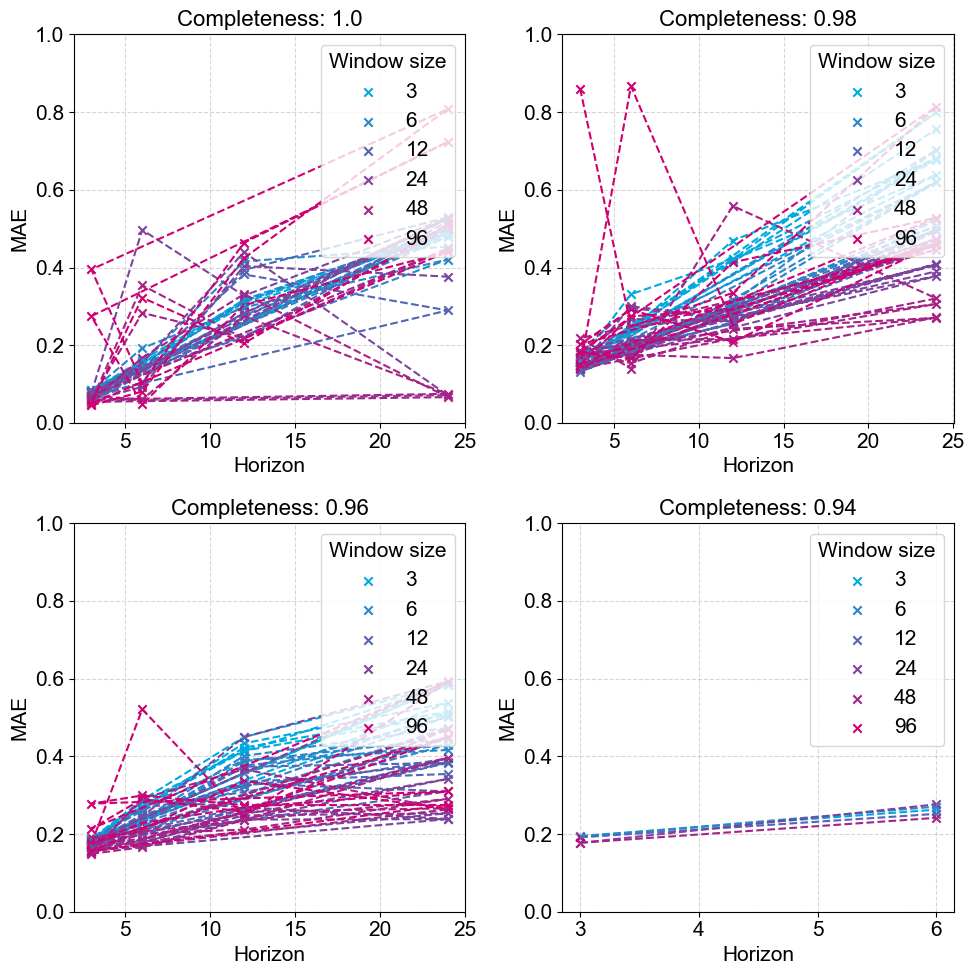

In [103]:
window_values = performance_lstm["WindowSize"].unique()
colors = custom_heatmap(
    np.linspace(0, 1, len(window_values))
)  # viridis colormap, you can choose any other

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
    for j, window_size in enumerate(window_values):
        data = performance_lstm[
            (performance_lstm["Completeness"] == completeness)
            & (performance_lstm["WindowSize"] == window_size)
        ]

        label = window_size
        ax[i // 2, i % 2].scatter(
            data["Horizon"], data["MAE"], color=colors[j], label=label, marker="x"
        )
        ax[i // 2, i % 2].plot(
            data["Horizon"], data["MAE"], color=colors[j], linestyle="--"
        )

    ax[i // 2, i % 2].legend(title="Window size", loc="upper right")
    ax[i // 2, i % 2].set_title(f"Completeness: {completeness}")
    ax[i // 2, i % 2].set_xlabel("Horizon")
    ax[i // 2, i % 2].set_ylabel("MAE")
    ax[i // 2, i % 2].set_ylim(0, 1)
    ax[i // 2, i % 2].grid(True, axis="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

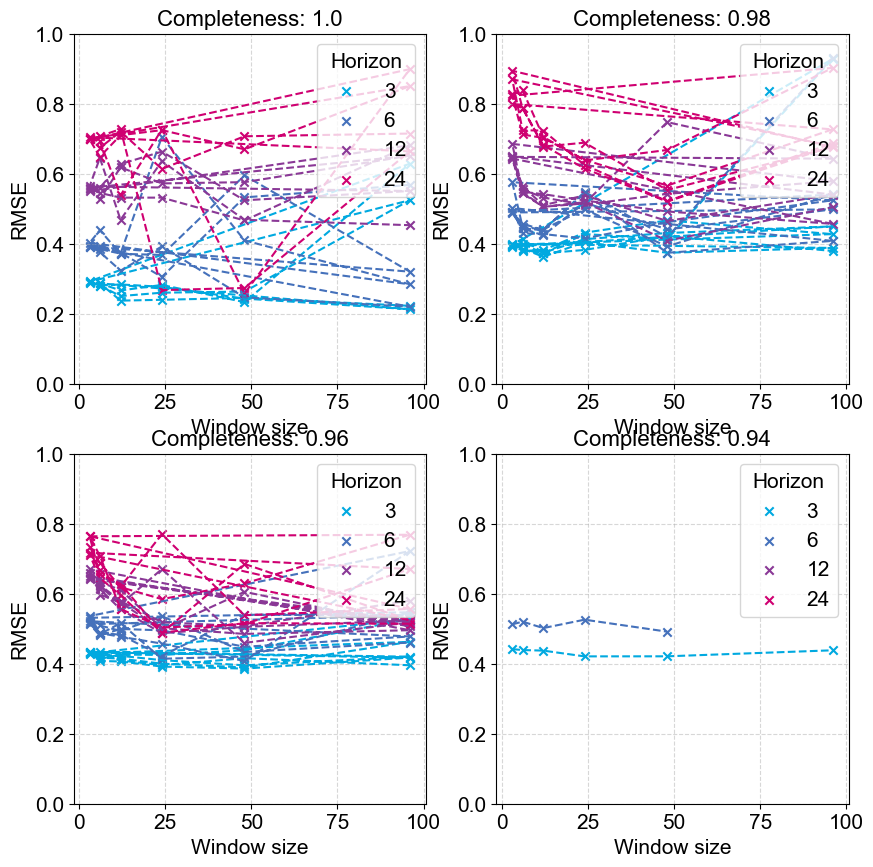

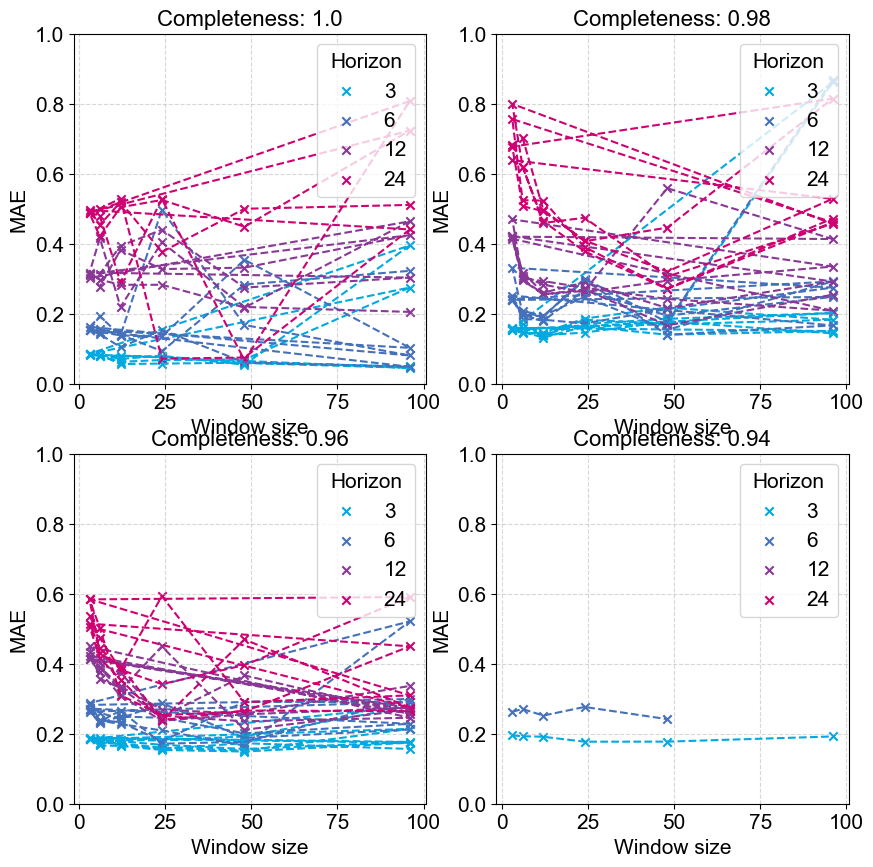

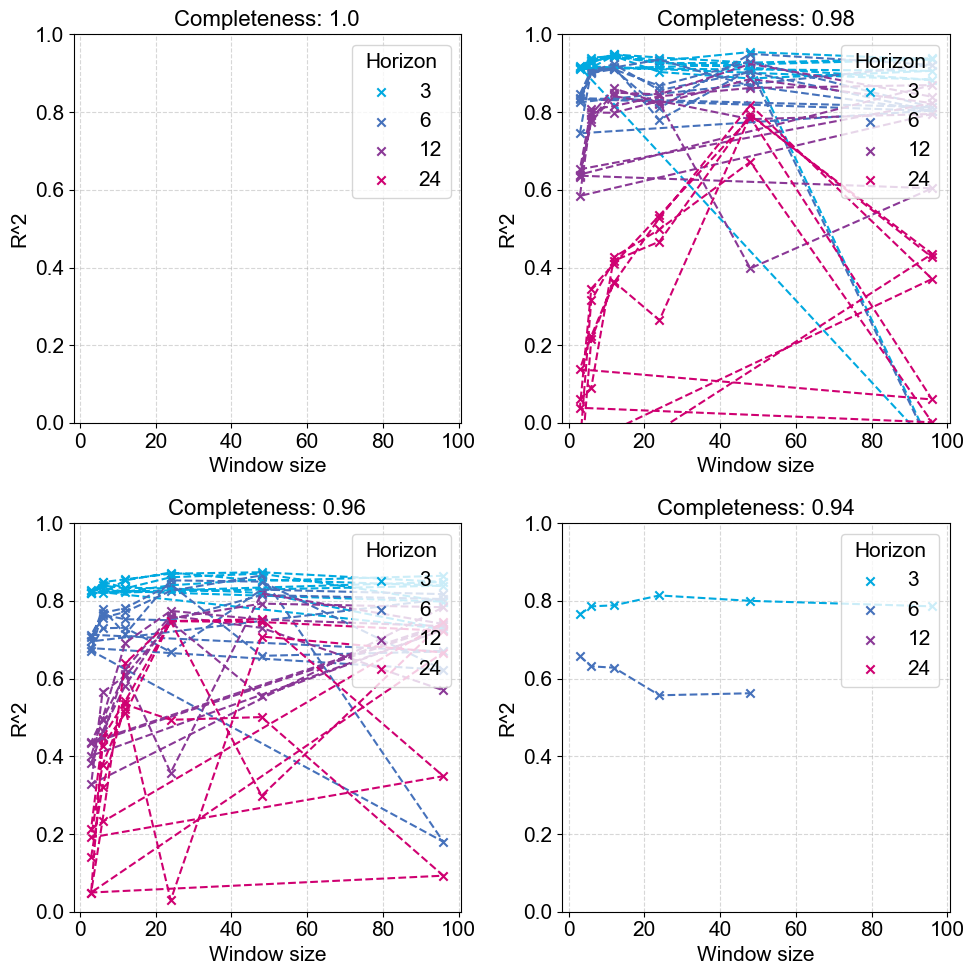

In [104]:
horizon_values = performance_lstm["Horizon"].unique()
colors = custom_heatmap(
    np.linspace(0, 1, len(horizon_values))
)  # viridis colormap, you can choose any other

for metric in ["RMSE", "MAE", "R^2"]:
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
        for j, horizon in enumerate(horizon_values):
            data = performance_lstm[
                (performance_lstm["Completeness"] == completeness)
                & (performance_lstm["Horizon"] == horizon)
            ]

            label = horizon
            ax[i // 2, i % 2].scatter(
                data["WindowSize"],
                data[metric],
                color=colors[j],
                label=label,
                marker="x",
            )
            ax[i // 2, i % 2].plot(
                data["WindowSize"], data[metric], color=colors[j], linestyle="--"
            )

        ax[i // 2, i % 2].legend(title="Horizon", loc="upper right")
        ax[i // 2, i % 2].set_title(f"Completeness: {completeness}")
        ax[i // 2, i % 2].set_xlabel("Window size")
        ax[i // 2, i % 2].set_ylabel(metric)
        ax[i // 2, i % 2].set_ylim(0, 1)
        ax[i // 2, i % 2].grid(True, which="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\carro\AppData\Local\Temp\ipykernel_22560\3286798771.py:56: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



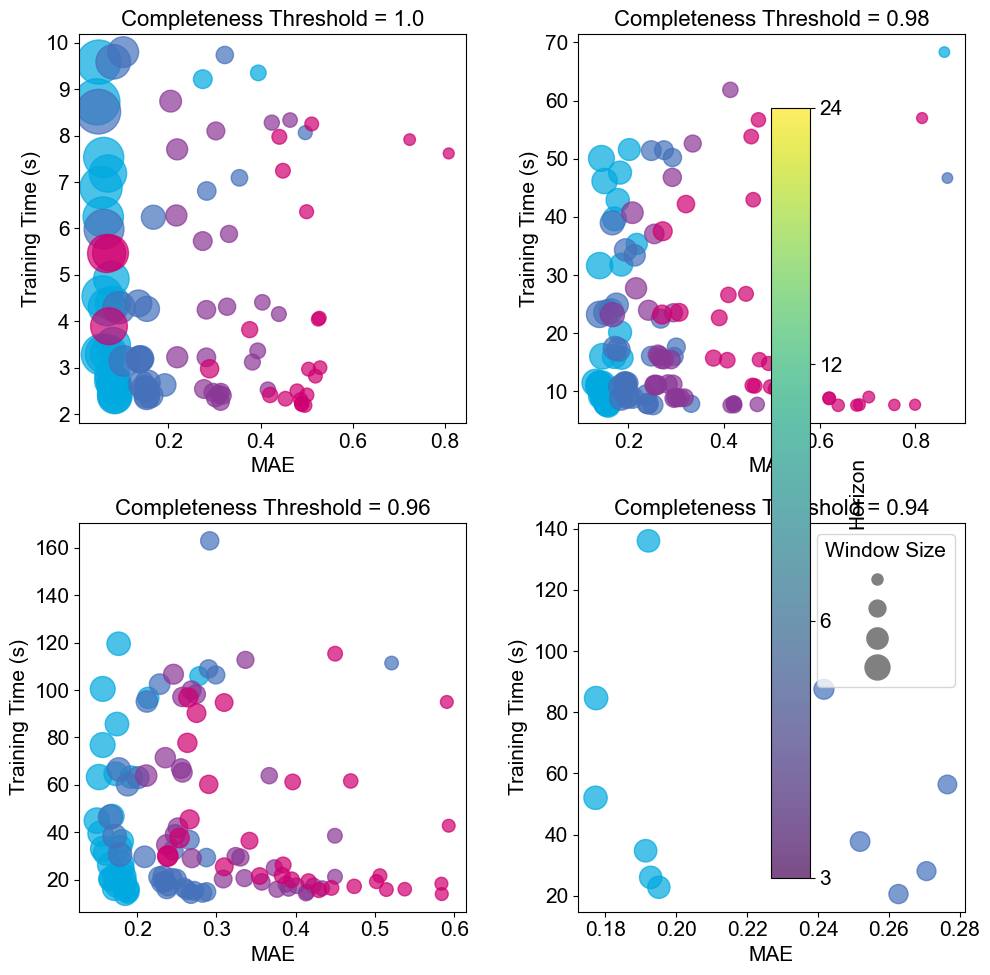

In [105]:
colors = custom_heatmap(np.linspace(0, 1, len(horizon_values)))
window_sizes = performance_lstm["WindowSize"].unique()
horizons = performance_lstm["Horizon"].unique()
completeness_thresholds = performance_lstm["Completeness"].unique()
horizons_list = list(horizons)
# Plotting
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
scatters = []
labels = []

performance_lstm = performance_lstm.sort_values(by="Horizon")

for i, completeness_threshold in enumerate(completeness_thresholds):
    subset = performance_lstm[
        performance_lstm["Completeness"] == completeness_threshold
    ]

    # Calculate point sizes according to the inverse of MAE
    mae = subset["MAE"].values  # Assuming MAE is a column in performance_lstm
    sizes = 1 / (mae + 1e-10)  # Adding a small value to prevent division by zero

    # Scatter plot
    sc = ax[i // 2, i % 2].scatter(
        subset["MAE"],
        subset["Training Time (s)"],
        c=[colors[horizons_list.index(h)] for h in subset["Horizon"].values],
        s=sizes * 50,  # Multiplying by 100 for better visibility
        label=[str(h) for h in subset["Horizon"].values],
        alpha=0.7,
    )
    scatters.append(sc)
    labels.extend(subset["Horizon"].unique())

    ax[i // 2, i % 2].set_title(f"Completeness Threshold = {completeness_threshold}")
    ax[i // 2, i % 2].set_xlabel("MAE")
    ax[i // 2, i % 2].set_ylabel("Training Time (s)")

# Adding legend for color (horizon)
cbar = fig.colorbar(sc, ax=ax.ravel().tolist(), orientation="vertical")
cbar.set_label("Horizon")
cbar.set_ticks(np.linspace(0, 1, len(horizons)))
cbar.set_ticklabels(horizons)

# Adding legend for size (inverse of MAE). This is a bit trickier.
# We create a custom legend using proxy artists.
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0], [0], marker="o", color="w", markersize=np.sqrt(s), markerfacecolor="gray"
    )
    for s in [100, 200, 300, 400]
]  # Adjust sizes as needed
ax[1, 1].legend(handles=legend_elements, title="Window Size")

fig.tight_layout()
plt.show()

In [106]:
performance_lstm

,MAE,MSE,RMSE,R^2,Training Time (s),Test Number,Completeness,Sequence Length,WindowSize,Horizon
1,0.083412,0.013734,0.288811,-1.812594,2.439272,2,1.00,216,3,3
171,0.131525,0.039016,0.362664,0.948702,11.466910,172,0.98,2082,12,3
172,0.163677,0.052451,0.404571,0.931758,23.848460,173,0.98,2082,24,3
173,0.140006,0.035576,0.374173,0.954772,31.622522,174,0.98,2082,48,3
174,0.150472,0.052735,0.387907,0.935660,46.161636,175,0.98,2082,96,3
...,...,...,...,...,...,...,...,...,...,...
307,0.449697,0.344027,0.670594,0.348933,115.328643,308,0.96,2576,96,24
306,0.263282,0.128262,0.513110,0.752682,77.702108,307,0.96,2576,48,24
305,0.253367,0.129225,0.503356,0.748023,37.550030,306,0.96,2576,24,24
191,0.620340,0.599833,0.787617,0.223616,8.799187,192,0.98,2082,6,24


(0.0, 1.2)

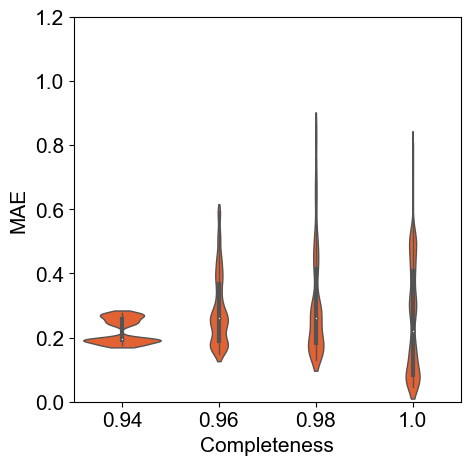

In [107]:
plt.figure(figsize=(5, 5))
sns.violinplot(
    x="Completeness",
    y="MAE",
    data=performance_lstm,
    bw=0.2,
    cut=1,
    linewidth=1,
    color=custom_palette[1],
    label="LSTM",
    alpha=0.5,
)
plt.ylim(0, 1.2)

(0.0, 1.2)

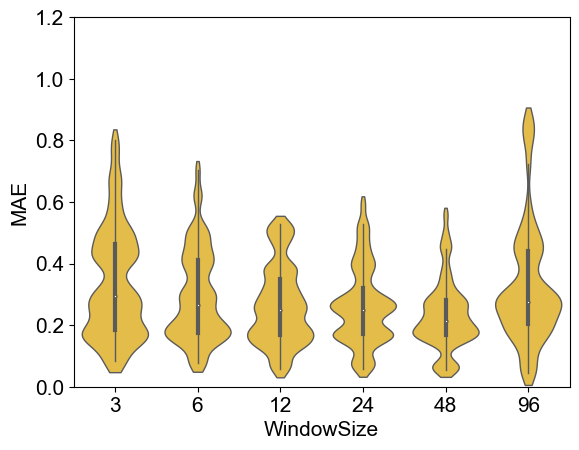

In [108]:
sns.violinplot(
    x="WindowSize",
    y="MAE",
    data=performance_lstm,
    bw=0.2,
    cut=1,
    linewidth=1,
    color=custom_palette[2],
    scale="width",
    scale_hue=False,
)
plt.ylim(0, 1.2)

In [109]:
performance_lstm

,MAE,MSE,RMSE,R^2,Training Time (s),Test Number,Completeness,Sequence Length,WindowSize,Horizon
1,0.083412,0.013734,0.288811,-1.812594,2.439272,2,1.00,216,3,3
171,0.131525,0.039016,0.362664,0.948702,11.466910,172,0.98,2082,12,3
172,0.163677,0.052451,0.404571,0.931758,23.848460,173,0.98,2082,24,3
173,0.140006,0.035576,0.374173,0.954772,31.622522,174,0.98,2082,48,3
174,0.150472,0.052735,0.387907,0.935660,46.161636,175,0.98,2082,96,3
...,...,...,...,...,...,...,...,...,...,...
307,0.449697,0.344027,0.670594,0.348933,115.328643,308,0.96,2576,96,24
306,0.263282,0.128262,0.513110,0.752682,77.702108,307,0.96,2576,48,24
305,0.253367,0.129225,0.503356,0.748023,37.550030,306,0.96,2576,24,24
191,0.620340,0.599833,0.787617,0.223616,8.799187,192,0.98,2082,6,24


In [110]:
len(performance_lstm["Sequence Length"].unique())

15

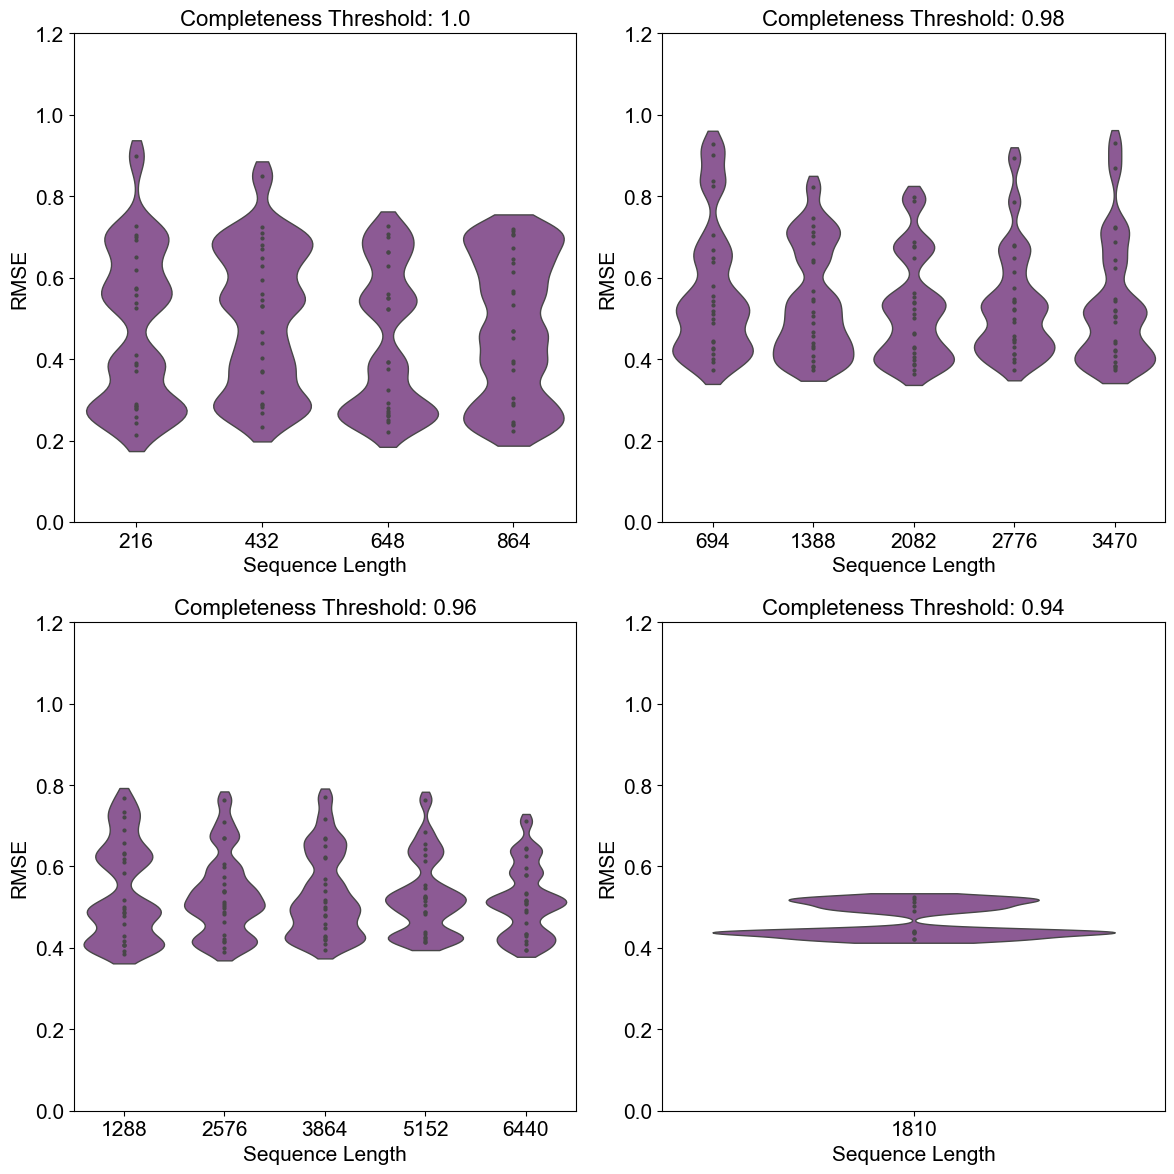

In [114]:
unique_thresholds = performance_lstm["Completeness"].unique()
n_thresholds = len(unique_thresholds)

# Create a 2x2 grid of subplots (or adjust as per your preference)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

for i, threshold in enumerate(unique_thresholds):
    data_subset = performance_lstm[performance_lstm["Completeness"] == threshold]
    sns.violinplot(
        x="Sequence Length",
        y="RMSE",
        data=data_subset,
        ax=axs[i],
        bw=0.2,
        cut=1,
        linewidth=1,
        color=custom_palette[5],
        inner="points",
        scale="width",
        scale_hue=True,
        gridsize=100,
    )
    axs[i].set_ylim(0, 1.2)
    axs[i].set_title(f"Completeness Threshold: {threshold}")

plt.tight_layout()
plt.show()

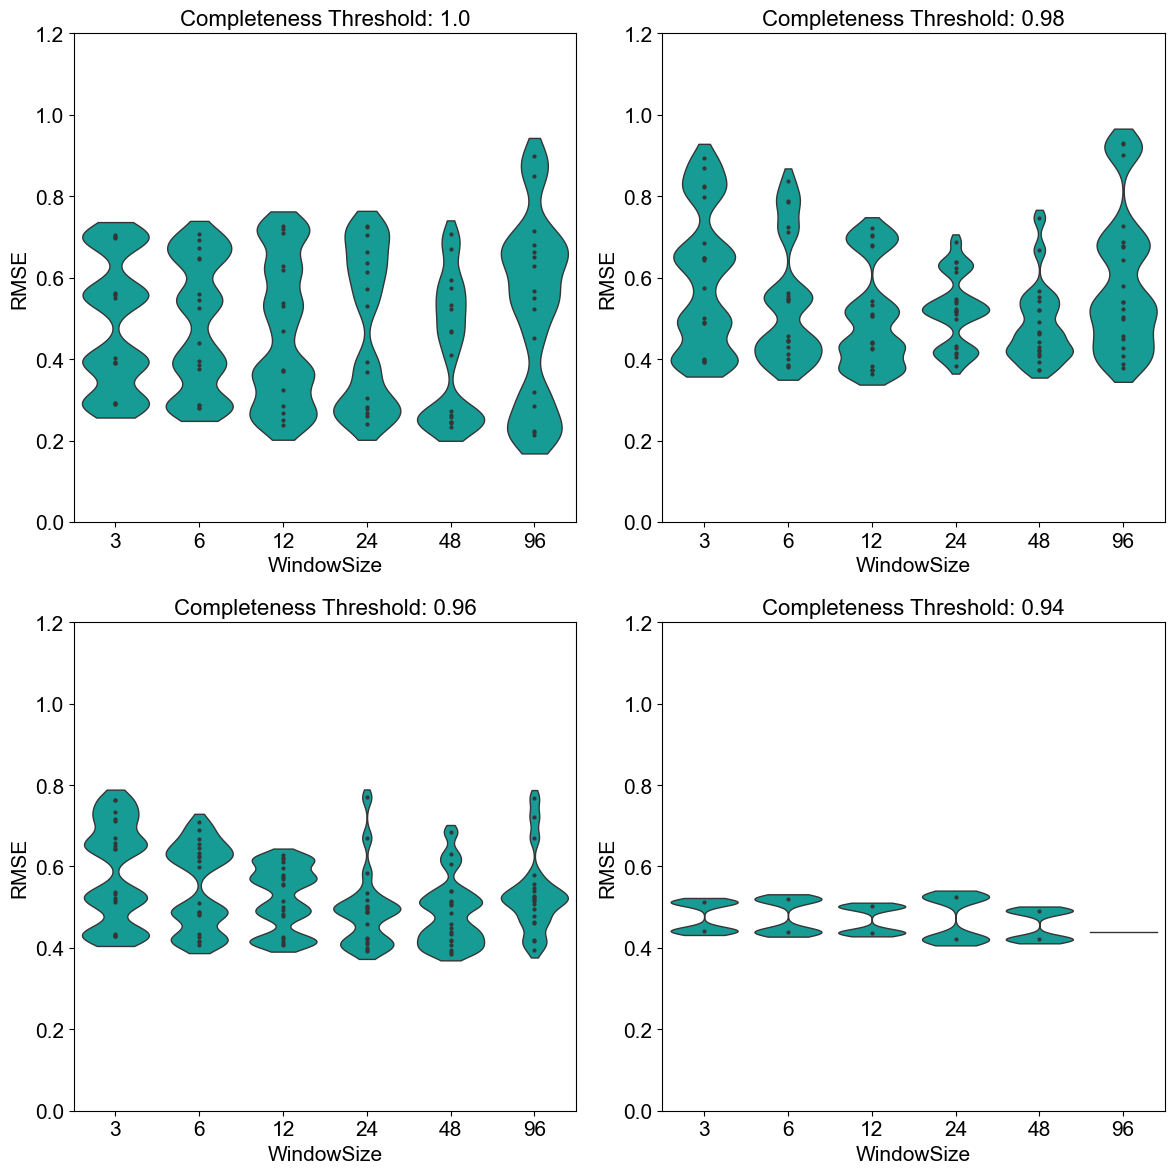

In [112]:
unique_thresholds = performance_lstm["Completeness"].unique()
n_thresholds = len(unique_thresholds)

# Create a 2x2 grid of subplots (or adjust as per your preference)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

for i, threshold in enumerate(unique_thresholds):
    data_subset = performance_lstm[performance_lstm["Completeness"] == threshold]
    sns.violinplot(
        x="WindowSize",
        y="RMSE",
        data=data_subset,
        ax=axs[i],
        bw=0.2,
        cut=1,
        linewidth=1,
        color=custom_palette[3],
        inner="points",
        scale="width",
        scale_hue=True,
        gridsize=100,
    )
    axs[i].set_ylim(0, 1.2)
    axs[i].set_title(f"Completeness Threshold: {threshold}")

plt.tight_layout()
plt.show()

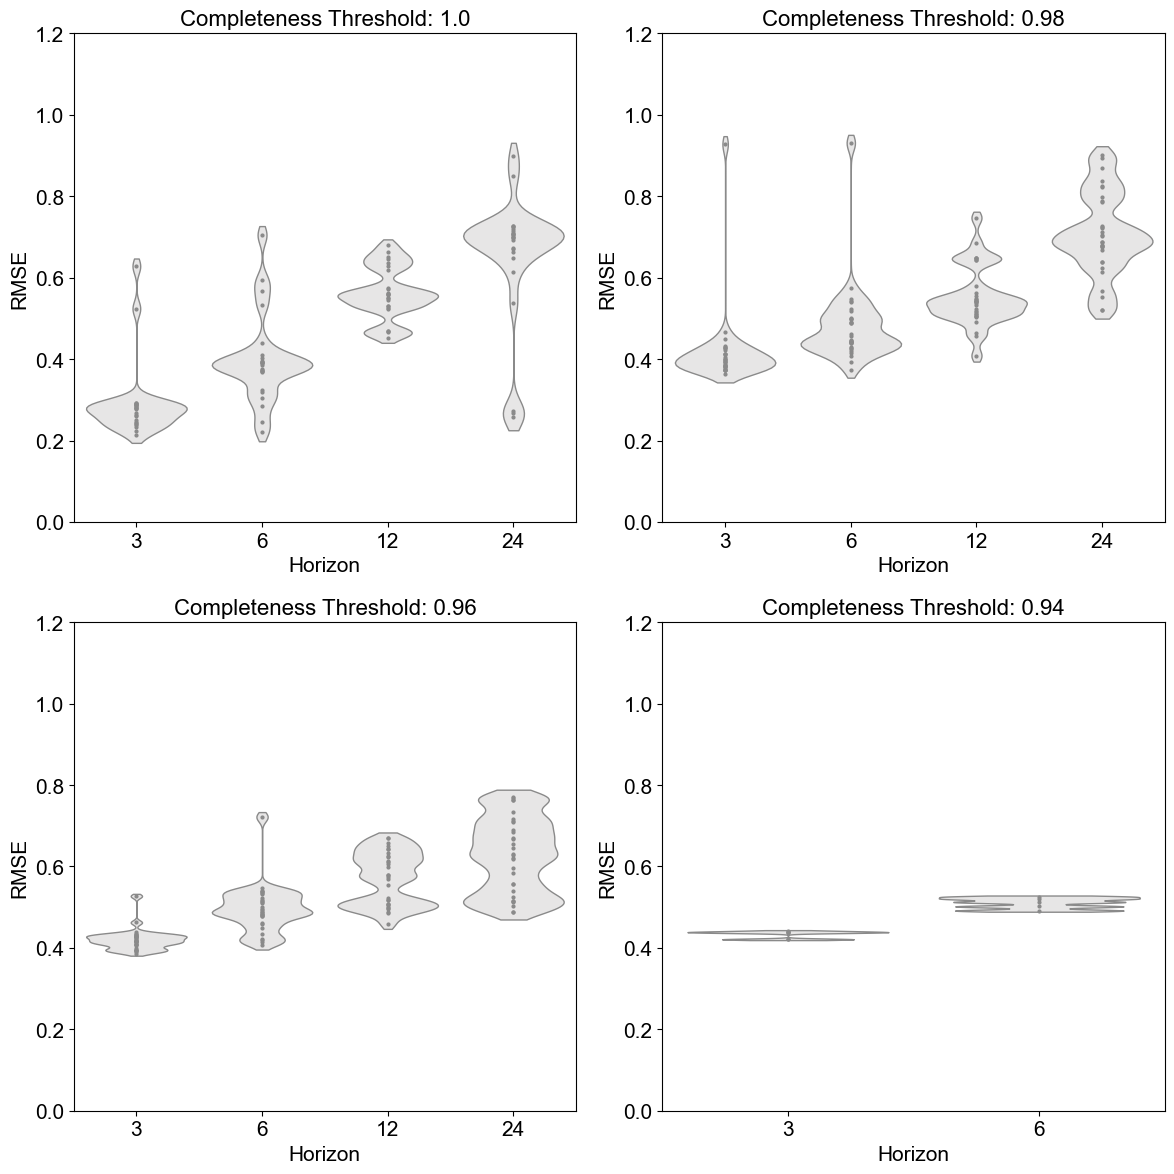

In [113]:
unique_thresholds = performance_lstm["Completeness"].unique()
n_thresholds = len(unique_thresholds)

# Create a 2x2 grid of subplots (or adjust as per your preference)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

for i, threshold in enumerate(unique_thresholds):
    data_subset = performance_lstm[performance_lstm["Completeness"] == threshold]
    sns.violinplot(
        x="Horizon",
        y="RMSE",
        data=data_subset,
        ax=axs[i],
        bw=0.2,
        cut=1,
        linewidth=1,
        color=custom_palette[4],
        inner="points",
        scale="width",
        scale_hue=True,
        gridsize=100,
    )
    axs[i].set_ylim(0, 1.2)
    axs[i].set_title(f"Completeness Threshold: {threshold}")

plt.tight_layout()
plt.show()